Source: [Emotion Detection Using Pytorch](https://jovian.ai/conero007/emotion-detection-resnet/v/1?utm_source=embed)

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
image_shape = (48, 48)
val_split = 0.25
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'gpu'

In [6]:
epochs = 16
max_lr = 0.0025
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [7]:
data_dir = '../resized_emoji_challenge_128_faces/'
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        print(f'{folder}: {len(os.listdir(os.path.join(data_dir, folder)))}')
classes = os.listdir(data_dir)

surprise: 12594
eye_roll: 11057
here_we_go: 16978
angry: 30971
disgust: 18314
sad: 2072
very_sad: 16970
cringe: 9848
clenched_teeth: 7743
kiss: 25600


In [8]:
train_tfms = tt.Compose([
    tt.Resize(image_shape), 
    tt.Grayscale(num_output_channels=1), 
    tt.ToTensor()
])

all_data = ImageFolder(data_dir, transform=train_tfms)
all_data = Subset(all_data, np.random.choice(len(all_data), 12000, replace=False))
print(len(all_data))
# train, val = torch.utils.data.random_split(all_data, [int((1-val_split)*len(all_data))+1, int(val_split*len(all_data))])
train, val = torch.utils.data.random_split(all_data, [10000, 2000])
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val, batch_size, shuffle=True, num_workers=3, pin_memory=True)

12000


torch.Size([1, 48, 48])


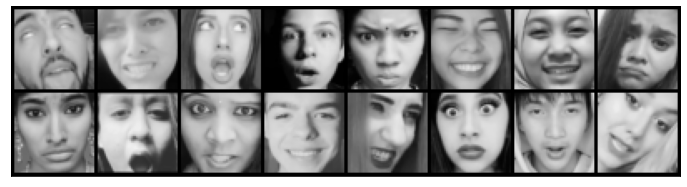

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_dl)

# Using a GPU
Transferring the model and data to 'cuda' if applicable

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

# Model Creation

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [17]:
@torch.no_grad()
def evaluate(model, val_loader): 
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer): 
    for param_group in optimizer.param_groups: 
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                 weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                              steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs): 
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader: 
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Train on original data

In [18]:
orig_model = to_device(ResNet(1, len(classes)), device)

In [20]:
orig_history = [evaluate(orig_model, valid_dl)]
orig_history

[{'val_loss': 2.2915642261505127, 'val_acc': 0.12049999833106995}]

In [23]:
%%time
orig_history += fit_one_cycle(epochs, max_lr, orig_model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00035, train_loss: 2.3711, val_loss: 1.8809, val_acc: 0.3385
Epoch [1], last_lr: 0.00099, train_loss: 2.3783, val_loss: 1.9370, val_acc: 0.3830
Epoch [2], last_lr: 0.00176, train_loss: 2.4603, val_loss: 1.9302, val_acc: 0.3725
Epoch [3], last_lr: 0.00234, train_loss: 2.2016, val_loss: 1.8911, val_acc: 0.3770
Epoch [4], last_lr: 0.00250, train_loss: 1.8927, val_loss: 1.8507, val_acc: 0.3395
Epoch [5], last_lr: 0.00243, train_loss: 1.7128, val_loss: 1.6801, val_acc: 0.4515
Epoch [6], last_lr: 0.00227, train_loss: 1.6052, val_loss: 1.5909, val_acc: 0.4845
Epoch [7], last_lr: 0.00203, train_loss: 1.5530, val_loss: 1.6292, val_acc: 0.5055
Epoch [8], last_lr: 0.00173, train_loss: 1.4945, val_loss: 1.7474, val_acc: 0.4140
Epoch [9], last_lr: 0.00139, train_loss: 1.4729, val_loss: 1.4982, val_acc: 0.5380
Epoch [10], last_lr: 0.00104, train_loss: 1.4383, val_loss: 1.5558, val_acc: 0.5065
Epoch [11], last_lr: 0.00071, train_loss: 1.4006, val_loss: 1.5163, val_acc: 0.5090
Ep

In [24]:
def plot_accuracies(history, label): 
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', label=label)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of epochs')

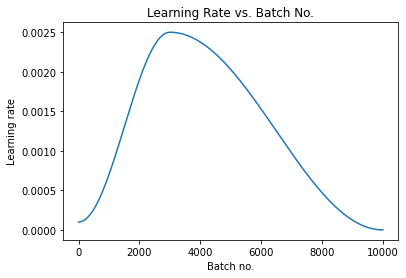

In [26]:
def plot_lrs(history): 
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch No.')
plot_lrs(orig_history)

### Saving the model

In [27]:
torch.save(orig_model.state_dict(), './model_ckpt/emotion_detection_original.pth')

# Training with cSAWGAN-GP images

In [28]:
data_dir = 'generated/csawgan_gp'
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        print(f'{folder}: {len(os.listdir(os.path.join(data_dir, folder)))}')
classes = os.listdir(data_dir)

surprise: 223
here_we_go: 680
angry: 694
disgust: 712
sad: 644
cringe: 709
kiss: 504


## Load cSAWGAN-GP data

In [29]:
train = ImageFolder(data_dir, transform=train_tfms)
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True)

torch.Size([1, 48, 48])


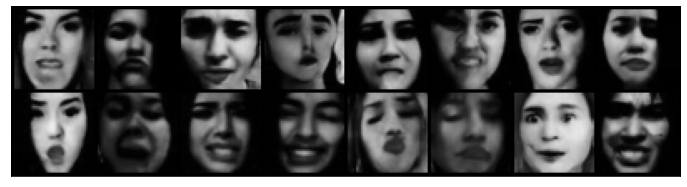

In [30]:
show_batch(train_dl)

In [31]:
train_dl = DeviceDataLoader(train_dl, device)

### Re-build cSAWGAN-GP model

In [32]:
wgan_gp_model = to_device(ResNet(1, len(classes)), device)

### Train cSAWGAN-GP model

In [33]:
wgan_gp_history = [evaluate(wgan_gp_model, valid_dl)]
wgan_gp_history

RuntimeError: CUDA error: device-side assert triggered

In [44]:
%%time
wgan_gp_history += fit_one_cycle(epochs, max_lr, wgan_gp_model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00035, train_loss: 2.7286, val_loss: 2.2209, val_acc: 0.1866
Epoch [1], last_lr: 0.00099, train_loss: 2.6915, val_loss: 2.2793, val_acc: 0.1778
Epoch [2], last_lr: 0.00176, train_loss: 2.8282, val_loss: 2.3942, val_acc: 0.1371
Epoch [3], last_lr: 0.00234, train_loss: 2.7215, val_loss: 2.3738, val_acc: 0.0975
Epoch [4], last_lr: 0.00250, train_loss: 2.4579, val_loss: 2.2698, val_acc: 0.1395
Epoch [5], last_lr: 0.00243, train_loss: 2.2888, val_loss: 2.1936, val_acc: 0.1958
Epoch [6], last_lr: 0.00227, train_loss: 2.2004, val_loss: 2.1970, val_acc: 0.1998
Epoch [7], last_lr: 0.00203, train_loss: 2.1619, val_loss: 2.1412, val_acc: 0.2181
Epoch [8], last_lr: 0.00173, train_loss: 2.1264, val_loss: 2.1506, val_acc: 0.2414
Epoch [9], last_lr: 0.00139, train_loss: 2.1015, val_loss: 2.0784, val_acc: 0.2641
Epoch [10], last_lr: 0.00104, train_loss: 2.0597, val_loss: 2.0751, val_acc: 0.2477
Epoch [11], last_lr: 0.00071, train_loss: 2.0260, val_loss: 2.0072, val_acc: 0.3001
Ep

In [ ]:
torch.save(wgan_gp_model.state_dict(), './model_ckpt/emotion_detection_csawgan_gp.pth')

# Training with cSAGAN images

In [30]:
data_dir = 'generated/csagan'
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        print(f'{folder}: {len(os.listdir(os.path.join(data_dir, folder)))}')
classes = os.listdir(data_dir)

surprise: 862
eye_roll: 787
here_we_go: 816
angry: 871
disgust: 862
sad: 786
very_sad: 843
cringe: 859
clenched_teeth: 826
kiss: 701


## Load cSAGAN data

In [39]:
train = ImageFolder(data_dir, transform=train_tfms)
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True)

torch.Size([1, 48, 48])


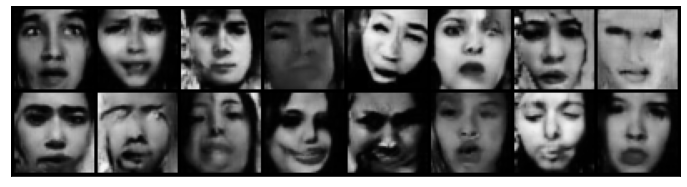

In [40]:
show_batch(train_dl)

In [41]:
train_dl = DeviceDataLoader(train_dl, device)

### Re-build replica model

In [ ]:
csagan_model = to_device(ResNet(1, len(classes)), device)

## Train model

In [ ]:
csagan_history = [evaluate(csagan_model, valid_dl)]
csagan_history

In [44]:
%%time
csagan_history += fit_one_cycle(epochs, max_lr, csagan_model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00035, train_loss: 2.7286, val_loss: 2.2209, val_acc: 0.1866
Epoch [1], last_lr: 0.00099, train_loss: 2.6915, val_loss: 2.2793, val_acc: 0.1778
Epoch [2], last_lr: 0.00176, train_loss: 2.8282, val_loss: 2.3942, val_acc: 0.1371
Epoch [3], last_lr: 0.00234, train_loss: 2.7215, val_loss: 2.3738, val_acc: 0.0975
Epoch [4], last_lr: 0.00250, train_loss: 2.4579, val_loss: 2.2698, val_acc: 0.1395
Epoch [5], last_lr: 0.00243, train_loss: 2.2888, val_loss: 2.1936, val_acc: 0.1958
Epoch [6], last_lr: 0.00227, train_loss: 2.2004, val_loss: 2.1970, val_acc: 0.1998
Epoch [7], last_lr: 0.00203, train_loss: 2.1619, val_loss: 2.1412, val_acc: 0.2181
Epoch [8], last_lr: 0.00173, train_loss: 2.1264, val_loss: 2.1506, val_acc: 0.2414
Epoch [9], last_lr: 0.00139, train_loss: 2.1015, val_loss: 2.0784, val_acc: 0.2641
Epoch [10], last_lr: 0.00104, train_loss: 2.0597, val_loss: 2.0751, val_acc: 0.2477
Epoch [11], last_lr: 0.00071, train_loss: 2.0260, val_loss: 2.0072, val_acc: 0.3001
Ep

In [ ]:
torch.save(csagan_model.state_dict(), './model_ckpt/emotion_detection_csawgan_gp.pth')